# Constituency methodology

## Introduction

When policy changes in the UK - taxes, benefits, or public spending - it affects places and people differently. PolicyEngine UK builds tools to analyze incomes, jobs, and population patterns in each constituency. This documentation explains how we create a microsimulation model that works at the constituency level. The system combines workplace surveys of jobs and earnings, HMRC tax records, and population statistics. We map data between 2010 and 2024 constituency boundaries, estimate income distributions, and optimize geographic weights.

This guide shows how to use PolicyEngine UK for constituency analysis. We start with data collection, transform it for modeling, and build tools to examine policies. The guide provides examples and code to implement these methods. Users can measure changes in household budgets, track employment, and understand economic patterns on different constituencies. This document starts with data collection from workplace surveys, tax records, and population counts, then explains how we convert this data into usable forms through income brackets and boundary mapping. It concludes with technical details about accuracy measurement and calibration, plus example code for analysis and visualization.

## Data

### Earning and jobs data

Data is extracted from NOMIS Annual Survey of Hours and Earnings (ASHE) - workplace analysis dataset, containing number of jobs and earnings percentiles for all UK parliamentary constituencies from [this website](https://www.nomisweb.co.uk/datasets/ashe). This dataset is stored as [`nomis_earning_jobs_data.xlsx`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/nomis_earning_jobs_data.xlsx). To download the data, follow the variable selection process shown in the image below:

![](pictures/nomis_screenshot1.png)

### Income data

Income data for UK parliamentary constituencies is obtained from [this government statistics report](https://www.gov.uk/government/statistics/income-and-tax-by-parliamentary-constituency-confidence-intervals). This dataset provides detailed information about income and tax by Parliamentary constituency with confidence intervals, and is stored as [`total_income.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/total_income.csv), including two key variables:

- [`total_income_count`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/total_income.csv#L1): the total number of taxpayers in each constituency

- [`total_income_amount`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/total_income.csv#L1): the total amount of income for all taxpayers in each constituency

We use these measures to identify similar constituencies when employment distribution data is missing. Our approach assumes that constituencies with similar income patterns (measured by both taxpayer counts and total income) will have similar earnings distributions. The following table shows the dataset:


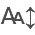

code                       name  total_income_count  \
0    E14000530                  Aldershot             56000.0   
1    E14000531        Aldridge-Brownhills             40000.0   
2    E14000532   Altrincham and Sale West             53000.0   
3    E14000533               Amber Valley             46000.0   
4    E14000534    Arundel and South Downs             56000.0   
..         ...                        ...                 ...   
645  W07000076                 Caerphilly             38000.0   
646  W07000077                     Islwyn             34000.0   
647  W07000078          Vale of Glamorgan             51000.0   
648  W07000079               Cardiff West             45000.0   
649  W07000080  Cardiff South and Penarth             50000.0   

     total_income_amount  
0           1.999200e+09  
1           1.312000e+09  
2           3.180000e+09  
3           1.389200e+09  
4           2.665600e+09  
..                   ...  
645         1.193200e+09  
646         9.656000e+08  
647         1.810500e+09  
648         1.647000e+09  
649         1.640000e+09  

[650 rows x 4 columns]

In [22]:
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

pd.read_csv("../policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/total_income.csv")

### Population data by age

Population data by age groups for UK parliamentary constituencies can be downloaded from the [House of Commons Library data dashboard](https://commonslibrary.parliament.uk/constituency-statistics-population-by-age/). The dataset provides detailed age breakdowns for each UK constituency, containing population counts for every age from 0 to 90+ years old across all parliamentary constituencies in England, Wales, Northern Ireland, and Scotland. The data is stored as [`age.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/age.csv). The following table shows the dataset:


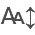

code                       name       all       0       1       2  \
0    E14000530                  Aldershot  105168.0  1313.0  1401.0  1436.0   
1    E14000531        Aldridge-Brownhills   77683.0   783.0   789.0   840.0   
2    E14000532   Altrincham and Sale West  102444.0   943.0  1058.0  1130.0   
3    E14000533               Amber Valley   92277.0   815.0   902.0   932.0   
4    E14000534    Arundel and South Downs  102673.0   789.0   779.0   903.0   
..         ...                        ...       ...     ...     ...     ...   
645  W07000076                 Caerphilly   88586.0   886.0   906.0   979.0   
646  W07000077                     Islwyn   76917.0   689.0   732.0   838.0   
647  W07000078          Vale of Glamorgan  105094.0   976.0  1050.0  1165.0   
648  W07000079               Cardiff West   94951.0  1116.0  1111.0  1132.0   
649  W07000080  Cardiff South and Penarth  118913.0  1282.0  1277.0  1392.0   

          3       4       5       6  ...     81     82     83     84     85  \
0    1294.0  1347.0  1491.0  1323.0  ...  513.0  455.0  449.0  362.0  317.0   
1     784.0   822.0   908.0   897.0  ...  634.0  638.0  568.0  461.0  412.0   
2    1198.0  1390.0  1287.0  1416.0  ...  610.0  557.0  511.0  455.0  436.0   
3    1008.0   957.0   964.0   939.0  ...  562.0  515.0  466.0  409.0  350.0   
4     938.0   984.0  1097.0  1052.0  ...  916.0  892.0  737.0  690.0  590.0   
..      ...     ...     ...     ...  ...    ...    ...    ...    ...    ...   
645  1029.0  1099.0  1053.0  1070.0  ...  491.0  477.0  387.0  363.0  334.0   
646   789.0   836.0   872.0   852.0  ...  463.0  405.0  351.0  338.0  312.0   
647  1261.0  1192.0  1271.0  1217.0  ...  656.0  592.0  531.0  447.0  389.0   
648  1165.0  1236.0  1274.0  1284.0  ...  436.0  422.0  353.0  359.0  273.0   
649  1406.0  1571.0  1511.0  1489.0  ...  516.0  513.0  405.0  421.0  355.0   

        86     87     88     89     90+  
0    322.0  230.0  186.0  179.0   802.0  
1    348.0  333.0  319.0  253.0   922.0  
2    376.0  346.0  311.0  292.0  1252.0  
3    327.0  318.0  237.0  191.0   897.0  
4    552.0  496.0  436.0  427.0  1562.0  
..     ...    ...    ...    ...     ...  
645  314.0  247.0  200.0  200.0   548.0  
646  304.0  200.0  201.0  161.0   606.0  
647  390.0  325.0  275.0  247.0   870.0  
648  294.0  250.0  218.0  178.0   695.0  
649  345.0  294.0  289.0  227.0   923.0  

[650 rows x 94 columns]

In [21]:
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

pd.read_csv("../policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/age.csv")

## Preprocessing

### Convert earning percentiles to brackets

To analyze earnings data effectively, we convert earning percentiles into earning brackets through the following process:

1. First, we estimate the full distribution of earnings by:
    - Using known percentile data (10th to 90th) from the ASHE dataset
    - Extending this to estimate the 90th-99th percentiles using ratios derived from [this government statistics report](https://www.gov.uk/government/statistics/percentile-points-from-1-to-99-for-total-income-before-and-after-tax#:~:text=Details,in%20the%20Background%20Quality%20Report)

2. This estimation allows us to map earnings data into brackets that align with policy thresholds.

The following code and visualization demonstrate this process using an example constituency:

```{code-block} python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data for Darlington
income_data = {
    'parliamentary constituency 2010': ['Darlington'],
    'constituency_code': ['E14000658'],
    'Number of jobs': ['31000'],
    '10 percentile': [13298.0],
    '20 percentile': [16723.0],
    '30 percentile': [20778.0],
    '40 percentile': [23407.0],
    '50 percentile': [27158.0],
    '60 percentile': [30471.0],
    '70 percentile': [33812.0],
    '80 percentile': [40717.0],
    '90 percentile': [55762.0],
    '91 percentile': [58878.0],
    '92 percentile': [62394.4],
    '93 percentile': [66722.3],
    '94 percentile': [71952.0],
    '95 percentile': [78804.5],
    '96 percentile': [87640.7],
    '97 percentile': [100083.5],
    '98 percentile': [123526.5],
    '100 percentile': [179429.0]
}

income_sample = pd.DataFrame(income_data)

# Excel Data Method
def load_real_data():
    # Read Excel data
    income_real = pd.read_excel("nomis_earning_jobs_data.xlsx", skiprows=7)
    income_real.columns = income_real.iloc[0]
    income_real = income_real.drop(index=0).reset_index(drop=True)
    
    # Select and rename columns
    columns_to_keep = [
        'parliamentary constituency 2010',
        'constituency_code',
        'Number of jobs',
        'Median',
        '10 percentile',
        '20 percentile',
        '30 percentile',
        '40 percentile',
        '60 percentile',
        '70 percentile',
        '80 percentile',
        '90 percentile'
    ]
    income_real = income_real[columns_to_keep]
    income_real = income_real.rename(columns={'Median': '50 percentile'})
    return income_real

# Plotting function
def plot_constituency_distribution(income_df, constituency_name, detailed=True):
    constituency_data = income_df[income_df['parliamentary constituency 2010'] == constituency_name].iloc[0]
    
    percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100]
    income_values = [
        0,
        constituency_data['10 percentile'],
        constituency_data['20 percentile'],
        constituency_data['30 percentile'],
        constituency_data['40 percentile'],
        constituency_data['50 percentile'],
        constituency_data['60 percentile'],
        constituency_data['70 percentile'],
        constituency_data['80 percentile'],
        constituency_data['90 percentile'],
        constituency_data['91 percentile'],
        constituency_data['92 percentile'],
        constituency_data['93 percentile'],
        constituency_data['94 percentile'],
        constituency_data['95 percentile'],
        constituency_data['96 percentile'],
        constituency_data['97 percentile'],
        constituency_data['98 percentile'],
        constituency_data['100 percentile']
    ]
    
    valid_data = [(p, v) for p, v in zip(percentiles, income_values) if pd.notna(v)]
    filtered_percentiles, filtered_income = zip(*valid_data)
    
    plt.figure(figsize=(8, 6))
    plt.plot(filtered_percentiles, filtered_income, marker='o')
    plt.xlabel('Percentiles')
    plt.ylabel('Income')
    plt.title(f'Income Distribution for {constituency_name}')
    plt.grid(True)
    plt.show()

# Plot sample data (Darlington with detailed percentiles)
plot_constituency_distribution(income_sample, 'Darlington', detailed=True)    
```

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data for Darlington
income_data = {
    'parliamentary constituency 2010': ['Darlington'],
    'constituency_code': ['E14000658'],
    'Number of jobs': ['31000'],
    '10 percentile': [13298.0],
    '20 percentile': [16723.0],
    '30 percentile': [20778.0],
    '40 percentile': [23407.0],
    '50 percentile': [27158.0],
    '60 percentile': [30471.0],
    '70 percentile': [33812.0],
    '80 percentile': [40717.0],
    '90 percentile': [55762.0],
    '91 percentile': [58878.0],
    '92 percentile': [62394.4],
    '93 percentile': [66722.3],
    '94 percentile': [71952.0],
    '95 percentile': [78804.5],
    '96 percentile': [87640.7],
    '97 percentile': [100083.5],
    '98 percentile': [123526.5],
    '100 percentile': [179429.0]
}

income_sample = pd.DataFrame(income_data)

# Excel Data Method
def load_real_data():
    # Read Excel data
    income_real = pd.read_excel("nomis_earning_jobs_data.xlsx", skiprows=7)
    income_real.columns = income_real.iloc[0]
    income_real = income_real.drop(index=0).reset_index(drop=True)
    
    # Select and rename columns
    columns_to_keep = [
        'parliamentary constituency 2010',
        'constituency_code',
        'Number of jobs',
        'Median',
        '10 percentile',
        '20 percentile',
        '30 percentile',
        '40 percentile',
        '60 percentile',
        '70 percentile',
        '80 percentile',
        '90 percentile'
    ]
    income_real = income_real[columns_to_keep]
    income_real = income_real.rename(columns={'Median': '50 percentile'})
    return income_real

# Plotting function
def plot_constituency_distribution(income_df, constituency_name, detailed=True):
    constituency_data = income_df[income_df['parliamentary constituency 2010'] == constituency_name].iloc[0]
    
    percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100]
    income_values = [
        0,
        constituency_data['10 percentile'],
        constituency_data['20 percentile'],
        constituency_data['30 percentile'],
        constituency_data['40 percentile'],
        constituency_data['50 percentile'],
        constituency_data['60 percentile'],
        constituency_data['70 percentile'],
        constituency_data['80 percentile'],
        constituency_data['90 percentile'],
        constituency_data['91 percentile'],
        constituency_data['92 percentile'],
        constituency_data['93 percentile'],
        constituency_data['94 percentile'],
        constituency_data['95 percentile'],
        constituency_data['96 percentile'],
        constituency_data['97 percentile'],
        constituency_data['98 percentile'],
        constituency_data['100 percentile']
    ]
    
    valid_data = [(p, v) for p, v in zip(percentiles, income_values) if pd.notna(v)]
    filtered_percentiles, filtered_income = zip(*valid_data)
    
    plt.figure(figsize=(8, 6))
    plt.plot(filtered_percentiles, filtered_income, marker='o')
    plt.xlabel('Percentiles')
    plt.ylabel('Income')
    plt.title(f'Income distribution for {constituency_name}')
    plt.grid(True)
    plt.savefig("pictures/earning_dist.png", dpi=300, bbox_inches='tight')
    plt.close()

# Plot sample data (Darlington with detailed percentiles)
plot_constituency_distribution(income_sample, 'Darlington', detailed=True)


![](pictures/earning_dist.png)

After estimating the full earnings distribution, we convert the data into income brackets. We calculate the number of jobs and total earnings for each constituency and income bracket based on the estimated earnings distribution. When we encounter constituencies with missing data, we estimate their earnings distribution pattern using data from constituencies with similar total number of taxpayers and total income levels. 

The Python script [`create_employment_incomes.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/create_employment_incomes.py) generates [`employment_income.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/employment_income.csv) containing number of jobs ([`employment_income_count`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/employment_income.csv#L1)) and total earnings ([`employment_income_amount`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/employment_income.csv#L1)) for each constituency and income bracket. The following table shows employment and income across different brackets for constituencies:


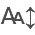

code                       name  employment_income_lower_bound  \
0     E14000530                  Aldershot                         200000   
1     E14000530                  Aldershot                         500000   
2     E14000530                  Aldershot                         300000   
3     E14000530                  Aldershot                              0   
4     E14000530                  Aldershot                          12570   
...         ...                        ...                            ...   
8445  W07000080  Cardiff South and Penarth                         100000   
8446  W07000080  Cardiff South and Penarth                         150000   
8447  W07000080  Cardiff South and Penarth                         200000   
8448  W07000080  Cardiff South and Penarth                              0   
8449  W07000080  Cardiff South and Penarth                         500000   

      employment_income_upper_bound  employment_income_count  \
0                          300000.0               660.099464   
1                               inf                 0.000000   
2                          500000.0                 0.000000   
3                           12570.0              1073.632697   
4                           15000.0               623.501391   
...                             ...                      ...   
8445                       150000.0              2510.857214   
8446                       200000.0              1920.943459   
8447                       300000.0                 0.000000   
8448                        12570.0               700.837422   
8449                            inf                 0.000000   

      employment_income_amount  
0                 1.650249e+08  
1                 0.000000e+00  
2                 0.000000e+00  
3                 6.747782e+06  
4                 8.594967e+06  
...                        ...  
8445              3.138572e+08  
8446              3.361651e+08  
8447              0.000000e+00  
8448              4.404763e+06  
8449              0.000000e+00  

[8450 rows x 6 columns]

In [20]:
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

pd.read_csv("../policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/employment_income.csv")

### Map constituency 2010 to 2024

PolicyEngine uses HMRC household data which aligns with 2010 constituency boundaries; to handle this issue and align it with 2024 constituency boundaries definitions, we follow these processes:

1. Download the mapping data from [this website](https://www.data.gov.uk/dataset/20c4ffe5-7d86-419f-808e-da98e46f4f52/westminster-pcon-may-2010-to-westminster-pcon-july-2024-lookup-in-the-uk-v2) that contains the official lookup table between 2010 and 2024 Westminster Parliamentary Constituencies.

2. Create a mapping matrix (650 x 650) which maps each constituency from 2010 to corresponding constituency in 2024 using the [`construct_mapping_matrix.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/mapping_2010_to_2024/construct_mapping_matrix.py) script. This is a many-to-many mapping, as 2010 constituencies can be split across multiple 2024 constituencies, and 2024 constituencies can contain parts of multiple 2010 constituencies. The matrix structure has rows representing 2010 constituencies and columns representing 2024 constituencies.

3. For each row in the matrix (representing a 2010 constituency), normalize the weights so they sum to 1. This ensures that when we redistribute data from 2010 boundaries to 2024 boundaries, we maintain the correct proportions.

The following table represents this mapping matrix:



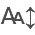

Unnamed: 0  E14001063  E14001064  E14001065  E14001066  E14001067  \
0    E14000530        0.5        0.0          0        0.0   0.000000   
1    E14000531        0.0        0.5          0        0.0   0.000000   
2    E14000532        0.0        0.0          1        0.0   0.000000   
3    E14000533        0.0        0.0          0        0.5   0.000000   
4    E14000534        0.0        0.0          0        0.0   0.333333   
..         ...        ...        ...        ...        ...        ...   
645  W07000076        0.0        0.0          0        0.0   0.000000   
646  W07000077        0.0        0.0          0        0.0   0.000000   
647  W07000078        0.0        0.0          0        0.0   0.000000   
648  W07000079        0.0        0.0          0        0.0   0.000000   
649  W07000080        0.0        0.0          0        0.0   0.000000   

     E14001294  E14001366  E14001599  E14001068  ...  W07000100  W07000087  \
0          0.0        0.0        0.0        0.0  ...        0.0        0.0   
1          0.0        0.0        0.0        0.0  ...        0.0        0.0   
2          0.0        0.0        0.0        0.0  ...        0.0        0.0   
3          0.0        0.0        0.0        0.0  ...        0.0        0.0   
4          0.5        0.5        0.5        0.0  ...        0.0        0.0   
..         ...        ...        ...        ...  ...        ...        ...   
645        0.0        0.0        0.0        0.0  ...        0.0        0.0   
646        0.0        0.0        0.0        0.0  ...        0.0        0.0   
647        0.0        0.0        0.0        0.0  ...        0.0        0.0   
648        0.0        0.0        0.0        0.0  ...        0.0        0.0   
649        0.0        0.0        0.0        0.0  ...        0.0        0.0   

     W07000085  W07000099  W07000106  W07000084  W07000086  W07000092  \
0          0.0        0.0        0.0       0.00        0.0   0.000000   
1          0.0        0.0        0.0       0.00        0.0   0.000000   
2          0.0        0.0        0.0       0.00        0.0   0.000000   
3          0.0        0.0        0.0       0.00        0.0   0.000000   
4          0.0        0.0        0.0       0.00        0.0   0.000000   
..         ...        ...        ...        ...        ...        ...   
645        0.0        0.0        0.0       0.25        0.0   0.000000   
646        0.0        0.0        0.0       0.25        0.0   0.000000   
647        0.0        0.0        0.0       0.00        0.0   0.000000   
648        0.0        0.0        0.0       0.00        0.0   0.333333   
649        0.0        0.0        0.0       0.00        0.0   0.000000   

     W07000088  W07000110  
0          0.0          0  
1          0.0          0  
2          0.0          0  
3          0.0          0  
4          0.0          0  
..         ...        ...  
645        0.5          0  
646        0.5          0  
647        0.0          1  
648        0.0          0  
649        0.0          0  

[650 rows x 651 columns]

In [23]:
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

pd.read_csv("../policyengine_uk_data/datasets/frs/local_areas/constituencies/mapping_2010_to_2024/mapping_matrix.csv")

## Methodology

### Loss function

The file [`loss.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/loss.py) defines a function [`create_constituency_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/loss.py#L18) that creates target matrices for comparing simulated data against actual constituency-level data. 

1. The function takes three main input parameters: dataset (defaults to [`enhanced_frs_2022_23`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/loss.py#L19)), time_period (defaults to 2025), and an optional reform parameter for policy changes.

2. It reads three files containing real data: [`age.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/age.csv), [`total_income.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/total_income.csv), and [`employment_income.csv`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/targets/employment_income.csv).

3. It creates a PolicyEngine Microsimulation object using the specified dataset and reform parameters.

4. The function creates two main matrices: [`matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/loss.py#L33) for simulated values from PolicyEngine, and [`y`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/loss.py#L34) for actual target values from both HMRC (income data) and ONS (age data).

5. It calculates total income metrics at the national level, computing both total amounts and counts of people with income.

6. It processes age distributions by creating 10-year age bands from 0 to 80, calculating how many people fall into each band.

7. For employment income, it processes both counts and amounts for different income bands between £12,570 and £70,000, excluding people under 16.

8. The [`sim.map_result()`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/loss.py#L88) function is used throughout to map individual-level results to household level.

9. The function returns both the simulated matrix and the target matrix [`(matrix, y)`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/loss.py#L34) which can be used for comparing the simulation results against actual data.

### Calibration function

The file [`calibrate.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/calibrate.py) defines a main [`calibrate()`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/calibrate.py#L25) function that performs weight calibration for constituency-level analysis.

1. It imports necessary functions and matrices from other files including [`create_constituency_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/calibrate.py#L16), [`create_national_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/calibrate.py#L17) from [`loss.py`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/loss.py), and [`transform_2010_to_2024`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/transform_constituencies.py#L7) for constituency boundary transformations.

2. Sets up initial matrices using the [`create_constituency_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/calibrate.py#L26) and [`create_national_target_matrix`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/calibrate.py#L28) functions for both constituency and national level data.

3. Creates a Microsimulation object using the [`enhanced_frs_2022_23`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/calibrate.py#L32) dataset.

4. Initializes weights for 650 constituencies x 100180 households, starting with the log of household weights divided by constituency count.

5. Converts all the matrices and weights into PyTorch tensors to enable optimization.

6. Defines a loss function that calculates and combines both constituency-level and national-level mean squared errors into a single loss value.

7. Uses Adam optimizer with a learning rate of 0.1 to minimize the loss over 512 epochs.

8. Every 100 epochs during optimization, it updates the weights using the mapping matrix from 2010 to 2024 constituencies and saves the current weights to a `weights.h5` file.

9. Includes an [`update_weights()`](https://github.com/PolicyEngine/policyengine-uk-data/blob/7c782c4839a024c729350a3ff2c76922bf21b0d4/policyengine_uk_data/datasets/frs/local_areas/constituencies/calibrate.py#L95) function that applies the constituency mapping matrix to transform the weights between different boundary definitions.

### Optimization mathematics

In this part, we explain the mathematics behind the calibration process that we discussed above. The optimization uses a two-part loss function that balances constituency-level and national-level accuracy, combining both local and national targets into a single optimization problem. The mathematical formulation can be expressed as follows:

For the constituency-level component, we have:
- A set of households ($j$) with known characteristics ($metrics_j$) like income, age, etc.
- A set of constituencies ($i$) with known target values ($y_c$) from official statistics
- Weights ($w_{ij}$) that we need to optimize for each household in each constituency 

Using these components, we calculate predicted constituency-level statistics. For each constituency metric (e.g. total income), the predicted value is:

$$ \text{pred}_c = \sum_j (\exp(w_{ij}) \times \text{metrics}_j) $$

where $\text{metrics}_j$ represents the household-level characteristics for that specific metric (e.g. household income). We use exponential of weights to ensure they stay positive.

To measure how well our predictions match the real constituency data, we calculate the constituency mean squared error:

$$ \text{MSE}_c = \text{mean}((\text{pred}_c / (1 + y_c) - 1)^2) $$

where $y_c$ are the actual target values from official statistics for each constituency. We use relative error (dividing by $1 + y_c$) to make errors comparable across different scales of metrics.

For the national component, we need to ensure our constituency-level adjustments don't distort national-level statistics. We aggregate across all constituencies:

$$ \text{pred}_n = \sum_i (\sum_j \exp(w_{ij})) \times \text{metrics}_\text{national} $$

with corresponding mean squared error to measure deviation from national targets:

$$ \text{MSE}_n = \text{mean}((\text{pred}_n / (1 + y_n) - 1)^2) $$

The total loss combines both constituency and national errors:

$$ L = \text{MSE}_c + \text{MSE}_n $$

We initialize the weights using the original household weights from the survey data:

$$ w_{\text{initial}} = \ln(\text{household}_{weight}/650) $$

where 650 is the number of constituencies. These weights are then iteratively optimized using the Adam (Adaptive Moment Estimation) optimizer with a learning rate of 0.1. The optimization process runs for 512 epochs, with the weights being updated in each iteration:

$$ w_{t+1} = w_t - 0.1 \times \nabla L(w_t) $$

This formulation ensures that the optimized weights maintain both local consistency at the constituency level and global accuracy for national-level statistics. The Adam optimizer adaptively adjusts the weights to minimize both constituency-level and national-level errors simultaneously, providing efficient convergence through adaptive learning rates and momentum. The resulting optimized weights allow us to accurately reweight household survey data to match both constituency-level and national statistics to obtain accurate estimates of income distributions, demographics, and policy impacts for each parliamentary constituency while maintaining consistency with national totals.

## Example

The following code demonstrates how to analyze and visualize median earnings across UK parliamentary constituencies using PolicyEngine:

```{code-block} python
# Import required libraries
from policyengine.utils.charts import *
from policyengine import Simulation

# Initialize simulation for visualization
sim = Simulation(
    country="uk",
    scope="macro",
    time_period="2025",
    options={
        "include_constituencies": True,  # Enable constituency-level analysis
    }
)

# Add fonts for visualization
add_fonts()

# Define function to calculate median earnings for adults
def adult_earnings_median(sim):
    # Filter for working age adults (18-65)
    adult = sim.calculate("age").between(18, 65)
    # Get employment income
    earnings = sim.calculate("employment_income")
    # Return median of positive earnings for adults
    return earnings[earnings > 0][adult].quantile(0.5)

# Create and display visualization of median earnings by constituency
sim.calculate(
    "macro/gov/local_areas/parliamentary_constituencies",
    metric=adult_earnings_median,
    chart=True
).update_layout(
    title="Median earnings of adults in parliamentary constituencies",
)
```

This code demonstrates how to:

1. Load and process constituency-level data using PolicyEngine's microsimulation capabilities

2. Calculate real household income and population metrics

3. Apply constituency weights to generate accurate geographic distributions

4. Create constituency-level visualizations of median earnings

5. Filter for working-age adults (18-65) and positive earnings

6. Generate an interactive visualization showing median earnings across parliamentary constituencies

The figure below shows the simulated results, displaying median earnings data across UK parliamentary constituencies in a geographic representation. The color intensity indicates earnings levels, providing an intuitive visualization of how earnings vary across different regions of the UK.

In [8]:
from policyengine.utils.charts import *
from policyengine import Simulation


sim = Simulation(
    country="uk",
    scope="macro",
    time_period="2025",
    options={
        "include_constituencies": True,
    }
)

add_fonts()

def adult_earnings_median(sim):
    adult = sim.calculate("age").between(18, 65)
    earnings = sim.calculate("employment_income")
    return earnings[earnings > 0][adult].quantile(0.5)

sim.calculate(
    "macro/gov/local_areas/parliamentary_constituencies",
    metric=adult_earnings_median,
    chart=True
).update_layout(
    title="Median earnings of adults in parliamentary constituencies",
).write_image("pictures/parliamentary_earnings.png", scale=6)

![](pictures/parliamentary_earnings.png)

<!-- ![](pictures/parliamentary_earnings.png) -->